# Data Load

In [1]:
# !wget https://drive.google.com/uc?id=1NWYqJgeG_4883LINdEjKUr6nLQPY6Yb_ -O data.txt

https://huggingface.co/datasets/cointegrated/ru-paraphrase-NMT-Leipzig

In [2]:
# !pip install youtokentome datasets

paranmt_ru_leipzig.tsv

In [3]:
import datasets
data = datasets.load_dataset(
    'cointegrated/ru-paraphrase-NMT-Leipzig',
    data_files={"train": "train.csv","val": "val.csv","test": "test.csv"},
)

Found cached dataset csv (C:/Users/Kirill/.cache/huggingface/datasets/cointegrated___csv/cointegrated--ru-paraphrase-NMT-Leipzig-f187aea54ca79219/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)


  0%|          | 0/3 [00:00<?, ?it/s]

# Import

In [4]:
from youtokentome import BPE

In [5]:
import pandas as pd
import nltk
from collections import Counter
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [6]:
from IPython.display import clear_output

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingLR

In [8]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Dataset

In [9]:
data['train']['original'][100]

'Во сне гадающей явится будущий муж.'

In [10]:
data['train']['en'][100]

'The future husband will appear in the dream of the diviner.'

In [11]:
df = pd.DataFrame()
df['en'] = data['train']['en']
df['ru'] = data['train']['original']
df = df.dropna().reset_index(drop=True)

In [12]:
# data = pd.read_csv('data.txt', sep='\t', names=['en', 'ru'])
# data['en'] = data['en'].apply(str)
# data['ru'] = data['ru'].apply(str)

In [13]:
# df = pd.concat([df, data], axis=0).reset_index(drop=True)
# df.head()

,en,ru
0,Prospects for the development of new media tec...,Перспективы развития новых медиатехнологий в Р...
1,But the number of TOPs per user is not limited!,А вот количество ТОП-ов от одного пользователя...
2,"As for the Zemstvo Council, at that time it di...","Что касается земского собора, у него в тот мом..."
3,Use special links to create an account to take...,Используйте специальные ссылки для создания ак...
4,"Thomason, who is rarely seen by locals, has a ...","Маячник Томасон, что редко для местных жителей..."


In [12]:
len(df)

979994

In [13]:
class YandexDataset(Dataset):
    def __init__(self, src: list, trg: list):
        self.src = src
        self.trg = trg

    def __getitem__(self, index):
        return {
            'src': self.src[index],
            'trg': self.trg[index],
        }

    def __len__(self):
        return len(self.src)

In [14]:
df['en'] = df['en'].apply(
    lambda item: item.lower()
).apply(
    lambda item: '<sos> ' + item + ' <eos>'
)

In [15]:
df['ru'] = df['ru'].apply(
    lambda item: item.lower()
).apply(
    lambda item: '<sos> ' + item + ' <eos>'
)

In [16]:
df['en'].to_csv('data_en.csv', index=False)
df['ru'].to_csv('data_ru.csv', index=False)

In [17]:
%%time
en_bpe = BPE.train(data="data_en.csv", vocab_size=20000, model="en_bpe.bin")
ru_bpe = BPE.train(data="data_ru.csv", vocab_size=45000, model="en_bpe.bin")

CPU times: total: 36.8 s
Wall time: 7.27 s


In [18]:
encoded = en_bpe.encode('<sos> hello friend! <eos>')
tokenized = ""
for word in encoded:
    tokenized += " " + en_bpe.id_to_subword(word)
tokenized

' ▁<sos> ▁hello ▁friend ! ▁<eos>'

In [19]:
src = df['en'].apply(
    en_bpe.encode
).values.tolist()

In [20]:
src[0]

[290,
 7955,
 312,
 247,
 1058,
 266,
 558,
 3277,
 3744,
 275,
 247,
 651,
 1973,
 382,
 300,
 4529,
 355,
 247,
 18006,
 853,
 25,
 3277,
 7007,
 252]

In [21]:
trg = df['ru'].apply(
    ru_bpe.encode
).values.tolist()

In [22]:
dict(zip(src[11], trg[11]))

{290: 543,
 5836: 10365,
 4229: 632,
 3549: 2789,
 434: 653,
 1507: 8915,
 16746: 35327,
 1601: 660,
 8369: 500,
 11649: 6739,
 3610: 16504,
 7048: 8649,
 346: 1746,
 6441: 22771,
 275: 52,
 9909: 33585,
 11095: 501,
 266: 11800,
 6175: 22972,
 252: 11479}

In [23]:
src_train, src_test, trg_train, trg_test = train_test_split(
    src[:],
    trg[:],
    random_state=42,
    test_size=0.25
)
src_train, src_valid, trg_train, trg_valid = train_test_split(
    src_train,
    trg_train,
    random_state=42,
    test_size=0.2
)

In [24]:
len(src_train), len(src_valid), len(src_test)

(587996, 146999, 244999)

In [25]:
train_data = YandexDataset(src_train, trg_train)
valid_data = YandexDataset(src_valid, trg_valid)
test_data = YandexDataset(src_test, trg_test)

In [26]:
def collate_fn(batch):
    max_src_len = max(len(row["src"]) for row in batch)
    max_trg_len = max(len(row["trg"]) for row in batch)
    max_len = max(max_src_len, max_trg_len)
    src_list = torch.empty((len(batch), max_len), dtype=torch.long)
    trg_list = torch.empty((len(batch), max_len), dtype=torch.long)

    for idx, row in enumerate(batch):
        to_pad_src = max_len - len(row["src"])
        to_pad_trg = max_len - len(row["trg"])
        _src = row['src']
        _trg = row['trg']
        src_list[idx] = torch.cat((torch.tensor(_src), torch.zeros(to_pad_src)))
        trg_list[idx] = torch.cat((torch.tensor(_trg), torch.zeros(to_pad_trg)))

    return {
        'src': src_list,
        'trg': trg_list,
    }

In [27]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_size=64, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, collate_fn=collate_fn)

In [28]:
for batch in train_loader:
    print(batch['src'].shape)
    print(batch['trg'].shape)
    break

torch.Size([64, 57])
torch.Size([64, 57])


In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [30]:
batch['src']

tensor([[ 290, 2122, 2854,  ...,    0,    0,    0],
        [ 290,  678,  301,  ...,    0,    0,    0],
        [ 290,  247, 1743,  ...,    0,    0,    0],
        ...,
        [ 290, 2087,  485,  ...,    0,    0,    0],
        [ 290,  543,  279,  ...,    0,    0,    0],
        [ 290, 4096,  708,  ...,  419,   22,  252]])

In [31]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Model

In [36]:
class Encoder(nn.Module):
    def __init__(self,
                 vocab_size: int,
                 embed_dim: int,
                 hidden_dim: int,
                 dropout: float = 0.2,
                 n_layers: int = 2,
                 bidirectional: bool = True
                ):
        super().__init__()
        self.vocab_size = vocab_size
        self.emb_dim = embed_dim
        self.hid_dim = hidden_dim
        self.n_layers = n_layers
        self.bidirectional = bidirectional

        self.embedding = nn.Embedding(vocab_size, embed_dim)

        self.rnn = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            batch_first=True,
        )

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # x = [batch_size, seq_len]
        embedded = self.dropout(self.embedding(x))

        # embedded = [batch_size, seq_len, emb_dim]
        out, (hidden, cell) = self.rnn(embedded)

        # out = [batch_size, seq_len, hidden_dim * 2]
        # hidden = [2 * n_layers, batch_size, hidden_dim]
        # cell = [2 * n_layers, batch_size, hidden_dim]
        if self.bidirectional:
#             hidden = hidden.transpose(0, 1).reshape(-1, self.n_layers, 2, self.hid_dim)
#             hidden = hidden.reshape(-1, self.n_layers, 2 * self.hid_dim)

#             cell = cell.transpose(0, 1).reshape(-1, self.n_layers, 2, self.hid_dim)
#             cell = cell.reshape(-1, self.n_layers, 2 * self.hid_dim)

            hidden = hidden.reshape(self.n_layers, 2, -1, self.hid_dim)
            hidden = hidden.transpose(1, 2).reshape(self.n_layers, -1, 2 * self.hid_dim)

            cell = cell.reshape(self.n_layers, 2, -1, self.hid_dim)
            cell = cell.transpose(1, 2).reshape(self.n_layers, -1, 2 * self.hid_dim)

        return out, hidden, cell

In [37]:
encoder = Encoder(
    vocab_size=en_bpe.vocab_size(),
    embed_dim=128,
    hidden_dim=128,
    n_layers=2,
    dropout=0.2,
    bidirectional=True
)

In [38]:
def softmax(x, temperature=10):
    e_x = torch.exp(x / temperature)
    return e_x / torch.sum(e_x, dim=1, keepdim=True)

In [39]:
class Attention(nn.Module):
    def __init__(self,
                 enc_hid_dim: int,
                 dec_hid_dim: int,
                 temperature: int = 1,
                ):
        super().__init__()

        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.temperature = temperature

        self.attn = nn.Linear(2 * enc_hid_dim + dec_hid_dim, enc_hid_dim)
        self.v = nn.Linear(enc_hid_dim, 1)

    def forward(self, hidden, encoder_outputs):
        # encoder_outputs = [batch_size, src_sec_len, enc_hid_dim]
        # hidden = [2, batch size, dec_hid_dim]
        last_hidden = hidden[-1, :, :].unsqueeze(1)
        hiddens = last_hidden.repeat(1, encoder_outputs.shape[1], 1)

        # repeat hidden and concatenate it with encoder_outputs
        concat_h_s = torch.concat([encoder_outputs, hiddens], dim=2)
        # concat_h_s = [src_seq_len, batch_size, 2 * enc_hid_dim]

        # calculate energy
        E = torch.tanh(self.attn(concat_h_s))
        # get attention, using softmax function with temperature
        a = self.v(E)

        return softmax(a, temperature=self.temperature)

In [40]:
attn = Attention(
    enc_hid_dim=128,
    dec_hid_dim=128 * 2,
    temperature=1.6,
)

In [41]:
class DecoderWithAttention(nn.Module):
    def __init__(self,
                 output_dim: int,
                 enc_hid_dim: int,
                 embed_dim: int,
                 hidden_dim: int,
                 n_layers: int,
                 attention,
                ):
        super().__init__()
        self.output_dim = output_dim
        self.enc_hid_dim = enc_hid_dim
        self.hid_dim = hidden_dim
        self.embed_dim = embed_dim
        self.n_layers = n_layers
        self.attention = attention

        self.embedding = nn.Embedding(output_dim, embed_dim)

        self.rnn = nn.GRU(
            input_size=embed_dim + enc_hid_dim * 2,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            bidirectional=False,
            batch_first=True,
        )

        self.fc = nn.Linear(hidden_dim + embed_dim + 2 * enc_hid_dim, output_dim)

    def forward(self, x, out, hidden):
        # x = [batch_size]
        # out = [batch_size, src_sec_len, enc_hid_dim]
        # hidden = [n_layers * n_directions, batch_size, hidden_dim]
        # cell = [n_layers * n_directions, batch_size, hidden_dim]
#         print(x.shape)

        x = x.unsqueeze(1)
        embedded = self.embedding(x)
        # embedded = [batch_size, 1, output_dim]

        # get weighted sum of encoder_outputs
        a_t = self.attention(hidden, out)
#         print(out.shape)
        # a_t = [batch_size, sec_len, 1]
        w_t = torch.sum(a_t * out, dim=1, keepdim=True)
        # w_t = [batch_size, 1, enc_hid_dim * n_directions]

        output, hidden = self.rnn(torch.concat([embedded, w_t], dim=2), hidden)

        predicted = self.fc(
            torch.cat(
                [embedded, # [batch_size, 1, emb_dim]
                 w_t, # [batch_size, 1, enc_hid_dim]
                 hidden[-1, :, :].unsqueeze(1) # [batch_size, 1, dec_hid_dim]
                ], dim=2
            ).squeeze(1)
        )

        return predicted, hidden

In [42]:
decoder = DecoderWithAttention(
    output_dim=ru_bpe.vocab_size(),
    enc_hid_dim=128,
    embed_dim=128,
    hidden_dim=128 * 2,
    n_layers=2,
    attention=attn,
)

In [43]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

        if encoder.bidirectional:
            assert encoder.hid_dim * 2 == decoder.hid_dim, \
                "Hidden dimensions of encoder and decoder must be equal!"
        else:
            assert encoder.hid_dim == decoder.hid_dim, \
                    "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"


    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        # src = [batch_size, seq_len]
        # trg = [batch_size, seq_len]

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        device = src.device

        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(device)

        encoder_outputs, hidden, cell = self.encoder(src)
        x = trg[:, 0]

        for t in range(1, trg_len):
            output, hidden = self.decoder(x, encoder_outputs, hidden)
            outputs[:, t] = output

            teacher_force = random.random() < teacher_forcing_ratio

            top1 = output.argmax(-1)

            x = trg[:, t] if teacher_force else top1

        return outputs

In [44]:
model = Seq2Seq(encoder, decoder)

In [45]:
model(batch['src'], batch['trg']).shape

torch.Size([64, 57, 45000])

In [46]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 38,778,057 trainable parameters


In [47]:
model.to(device)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(20000, 128)
    (rnn): LSTM(128, 128, num_layers=2, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): DecoderWithAttention(
    (attention): Attention(
      (attn): Linear(in_features=512, out_features=128, bias=True)
      (v): Linear(in_features=128, out_features=1, bias=True)
    )
    (embedding): Embedding(45000, 128)
    (rnn): GRU(384, 256, num_layers=2, batch_first=True)
    (fc): Linear(in_features=640, out_features=45000, bias=True)
  )
)

In [48]:
epochs = 2
PAD_IDX = 0
optimizer = optim.Adam(model.parameters(), lr=3e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=int(len(train_loader) + 1) * epochs)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [49]:
def train(model, iterator, optimizer, scheduler, criterion, clip, train_history=None, valid_history=None):
    model.train()

    epoch_loss = 0
    history = []
    i = 0
    for batch in tqdm(iterator):

        src = batch['src'].to(device)
        trg = batch['trg'].to(device)

        optimizer.zero_grad()

        output = model(src, trg)

        # trg = [batch_size, trg_sent_len]
        # output = [batch_size, trg_sent_len, output_dim]

        output = output[:, 1:, :].reshape(-1, ru_bpe.vocab_size())
        trg = trg[:, 1:].reshape(-1)

        # trg = [(trg_sent_len - 1) * batch size]
        # output = [(trg_sent_len - 1) * batch size, output dim]

        loss = criterion(output, trg)

        loss.backward()

        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()

        history.append(loss.cpu().data.numpy())
        if (i + 1) % 10 == 0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()

            plt.show()
        i += 1

    return epoch_loss / len(iterator)


def evaluate(model, iterator, criterion):

    model.eval()
    epoch_loss = 0
    history = []

    with torch.no_grad():
        for batch in tqdm(iterator):

            src = batch['src'].to(device)
            trg = batch['trg'].to(device)

            # trg = [batch size, trg_sent_len]
            # src = [batch size, src_sent_len]

            output = model(src, trg, 0) #turn off teacher forcing
            # output = [batch size, trg_sent_len, output dim]

            output = output[:, 1:, :].reshape(-1, ru_bpe.vocab_size())
            trg = trg[:, 1:].reshape(-1)

            # trg = [(trg_sent len - 1) * batch_size]
            # output = [(trg_sent_len - 1) * batch_size, output_dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

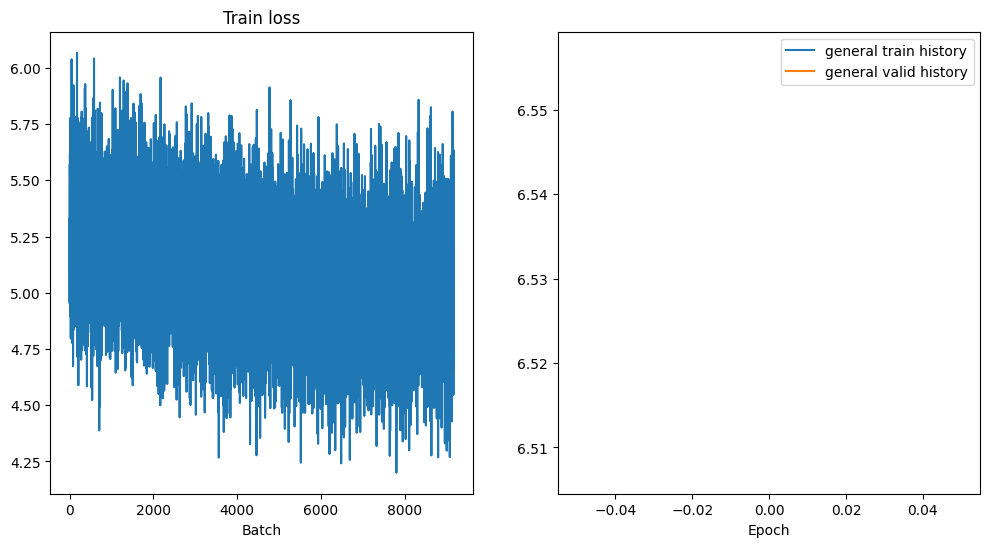

100%|██████████████████████████████████████████████████████████████████████████████| 2297/2297 [08:40<00:00,  4.41it/s]


In [50]:
train_history = []
valid_history = []
for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer, scheduler, criterion, 2, train_history, valid_history)
    valid_loss = evaluate(model, valid_loader, criterion)

    train_history.append(train_loss)
    valid_history.append(valid_loss)

In [51]:
def remove_tech_tokens(tokens: list, bpe):
    result = []
    for token in tokens:
       if token not in [
           en_bpe.subword_to_id('▁<eos>'), ru_bpe.subword_to_id('▁<eos>'), en_bpe.subword_to_id('▁<sos>'), ru_bpe.subword_to_id('▁<sos>'), 0]:
          result.append(token)
    return result

In [56]:
batch = next(iter(test_loader))

for idx in range(0, 10):
    src = batch['src'][idx:idx+1, :]
    trg = batch['trg'][idx:idx+1, :]
    model.eval()
    output = model(src.to(device), trg.to(device), 0)
    output = output[:, 1:, :].reshape(-1, ru_bpe.vocab_size()).argmax(1)

    original = en_bpe.decode(remove_tech_tokens(src.cpu().numpy()[0].tolist(), en_bpe))
    generated = ru_bpe.decode(remove_tech_tokens(output.cpu().numpy().tolist(), ru_bpe))

    print(original)
    print(generated)
    print()

['the nights here are cold, and we are not thick-skinned enough not to freeze.']
['здесь здесь холод, холод и мы не толстые не не не не']

['development, support, promotion of sites.']
['разработ разработки разработка продвижение сайтов. сайтов. сайтов.']

['this level controls the other six levels.']
['этот уровень контролирует другой уровень']

['the freedom to feel, to feel, to be sensual again, and the freedom to go beyond the mind.']
['свобода ощутить чувствовать чувствовать чувствовать чувственным, и и свобода и выйти к ума. разума.']

['the trainee flew all ten metres, climbed over the railings and went down, but after ten seconds he came out of the air again right next to the portal.']
['в времялетел в десять метров, на на на на и и и а после десять секунд секунд вышел из воздуха рядом с порта порта порта порта порта порта порта порта порта порта порта портала.']

['in the morning i go to work on the first train, but return on the last one and have to walk along this tunnel in 

In [55]:
from nltk.translate.bleu_score import corpus_bleu

In [101]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for batch in tqdm(test_loader):

        src = batch['src'].to(device)
        trg = batch['trg'].to(device)

        output = model(src.to(device), trg.to(device), 0)
        output = output[:, 1:, :].reshape(-1, ru_bpe.vocab_size()).argmax(1)

        original = ru_bpe.decode(remove_tech_tokens(trg.reshape(-1).cpu().numpy().tolist(), ru_bpe))
        generated = ru_bpe.decode(remove_tech_tokens(output.cpu().numpy().tolist(), ru_bpe))

        original_text.append(original)
        generated_text.append(generated)

100%|██████████████████████████████████████████████████████████████████████████████| 3829/3829 [14:37<00:00,  4.36it/s]


In [102]:
corpus_bleu([[text[0].split()] for text in original_text], [text[0].split() for text in generated_text]) * 100

6.072474309451069

In [106]:
generated_text[0][0][:200]

'здесь здесь холод, холод и мы не толстые не не не не разработ разработки разработка продвижение сайтов. сайтов. сайтов. этот уровень контролирует другой уровень свобода ощутить чувствовать чувствовать'

In [107]:
original_text[0][0][:200]

'ночи здесь холодные, а мы не настолько толстокожие, чтобы не мерзнуть. разработка, поддержка, раскрутка сайтов. этот уровень управляет остальными шестью уровнями. свободу ощущать, чувствовать, снова б'